## Load Google's pretrained word2vec model 

In [1]:
"""
imports
"""
import numpy as np
import gensim                             # belongs to gensim package
from smart_open import open as smart_open # belongs to smart_open package

"""
load model, located in a 'models' folder
download it yourself, and do not put it in the github repo
(i.e. put it in your .gitignore file) because it's YUGE
download: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing
"""
with smart_open('./models/GoogleNews-vectors-negative300.bin', 'rb') as word2vec_file:
    model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_file, binary=True)

/home/alex/Software/anaconda3/envs/dl/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [2]:
"""
Putting model to use
notes:
 - model is made to produce 300D vectors
 - can't turn vectors into words
"""
model.get_vector("hi")
model.get_vector("Yagmur")

Help on Word2VecKeyedVectors in module gensim.models.keyedvectors object:

class Word2VecKeyedVectors(WordEmbeddingsKeyedVectors)
 |  Word2VecKeyedVectors(vector_size)
 |  
 |  Mapping between words and vectors for the :class:`~gensim.models.Word2Vec` model.
 |  Used to perform operations on the vectors such as vector lookup, distance, similarity etc.
 |  
 |  Method resolution order:
 |      Word2VecKeyedVectors
 |      WordEmbeddingsKeyedVectors
 |      BaseKeyedVectors
 |      gensim.utils.SaveLoad
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  get_keras_embedding(self, train_embeddings=False)
 |      Get a Keras 'Embedding' layer with weights set as the Word2Vec model's learned word embeddings.
 |      
 |      Parameters
 |      ----------
 |      train_embeddings : bool
 |          If False, the weights are frozen and stopped from being updated.
 |          If True, the weights can/will be further trained/updated.
 |      
 |      Returns
 |      -------
 |      

## Load the arxiv data

In [3]:
import json
DATAPATH = "data/articles.json"

with open(DATAPATH, "r", encoding="utf-8") as f:
    articles = json.load(f)
    
all_categories = []
articles_dict = dict()
for article in articles:
    category = article["category"]
    if category not in all_categories:
        all_categories.append(category)
        articles_dict[category] = []
    articles_dict[category].append(article)
    
n_categories = len(arcticles_dict.keys())

## Turning abstracts into pytorch tensors

In [4]:
import re
text = "Hi David, I'm just testing this. Please pay attention to me."
y = lambda x: re.sub("[^\w'-]", " ",  x).split()
y(text)

['Hi',
 'David',
 "I'm",
 'just',
 'testing',
 'this',
 'Please',
 'pay',
 'attention',
 'to',
 'me']

In [17]:
import torch
import string
import unicodedata
import re

tokenize = lambda x: re.sub("[^\w'-]", " ",  x).split()


def lineToTensor(text):
    words = tokenize(text)
    vectors = []
    for word in words:
        try:
            vector = model.get_vector(word)
            vectors.append(vector)
        except:
            pass
        
    #create 3D tensor with the shape which is proper for the LSTM
    return torch.tensor([[v] for v in vectors])

torch.Size([10, 1, 300])


## Creating the RNN architecture

In [18]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        
        self.i2h = nn.LSTM(input_size, hidden_size, 1)
        
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        hidden , (h_t, c_t) = self.i2h(input)
        output = self.h2o(hidden[-1])
        output = self.softmax(output)
        return output
    
rnn=LSTM(300, 300, n_categories)

## Preparing for training

In [19]:
def categoryFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(rnn(lineToTensor("some random line here"))))

('Economics', 2)


In [20]:
from random import choice

def randomTrainingExample():
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(articles_dict[category])
    abstract = article["abstract"]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor, abstract_tensor

randomTrainingExample()

('Quantitative Biology',
 'We analyze the fate of dynamical systems that consist of two kind of\nprocesses. The first type is supposed to perform a certain function by\nprocessing information at a required high accuracy, which is, however, limited\nto less than 100 percent, while the second process serves to maintain the\nrequired precision. Both processes are assumed to be subject to a trade-off\nbetween cost and precision, where the cost have to be paid from renewable but\nlimited resources. In a discrete map we pursue the time evolution of errors and\ndetermine the conditions under which the fate of the system is either a stable\nperformance at the desired accuracy, or a deterioration. Deterioration may be\nrealized either as an accumulation of errors or a decline of resources when\nthey are all absorbed for maintenance. We point to possible implications for\nliving organisms and their perspectives to avoid an accumulation of errors in\nthe course of time.',
 tensor([5]),
 tensor([[

## Training the network

In [21]:
import torch.optim as optim

learning_rate = 0.01

criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

def train(category_tensor, abstract_tensor):
    optimizer.zero_grad()
    
    output = rnn(abstract_tensor)
            
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
        
    return output, loss.item()

In [22]:
import time

n_iters = 500
print_every = 100
plot_every = 10

# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

start = time.time()

for it in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, it/n_iters*100, timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0

100 20.0% (0.0m 22.738040447235107s) 1.786 / Computer Science V
200 40.0% (0.0m 40.76829504966736s) 2.212 / Economics X Electrical Engineering and Systems Science
300 60.0% (0.0m 57.51316237449646s) 1.719 / Physics V
400 80.0% (1.0m 13.751345157623291s) 2.341 / Electrical Engineering and Systems Science X Computer Science
500 100.0% (1.0m 29.86014485359192s) 2.19 / Electrical Engineering and Systems Science X Quantitative Finance


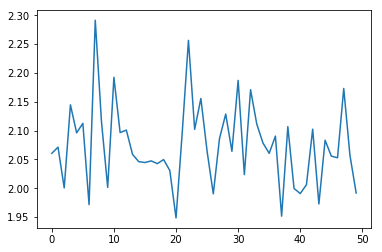

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)